### Load necessary Libraries

In [25]:
using MAT, PyPlot, Optim, Logging
Logging.configure(output=open("data_prediction_GP.log", "a"), level=INFO)
push!(LOAD_PATH, "../src")
using GP

### Load .mat recorded neural data

In [26]:
data_dir = "../data/"

datasets = Dict[];
for (ixf, f) in enumerate(readdir(data_dir))
    if ixf in [2, 6]; continue; end # skipping datasets 2 and 6 due to noise
    if f[end-2:end] != "mat"
        continue
    end
    f = data_dir * f # full file path
    file = matopen(f) # open the data file
    
    # 1 of 2 possible choices
    if exists(file, "S")
        push!(datasets, read(file, "S"))
    elseif exists(file, "ST")
        push!(datasets, read(file, "ST"))
    end
    if "seqnum" in keys(datasets[end]) # invalid datasets
        delete!(datasets[end], "seqnum")
    end
    
    close(file) # close the data file
end

ndsets = length(datasets)
println(@sprintf("# datasets: %d", ndsets))

# datasets: 5


In [27]:
# limit the data to single gratings at max contrast
for ix in 1:ndsets
    cond_mask = datasets[ix]["stimuli"][:, 1] .== 1
    cond_mask = cond_mask & (datasets[ix]["stimuli"][:, 4] .== 100)
    
    trial_mask = find(cond_mask[datasets[ix]["condVec"]])
    
    datasets[ix]["condVec"] = round(Int64, datasets[ix]["condVec"][trial_mask])
    datasets[ix]["spikeTimes"] = datasets[ix]["spikeTimes"][:, trial_mask]
    datasets[ix]["spikeCounts"] = datasets[ix]["spikeCounts"][:, trial_mask]
end

### Count spikes and reformat

In [28]:
window = [20, 70] # in msec, the window with which to count spikes in
d = (window[2] - window[1]) / 1000. # normalization factor
counter = x -> sum((x .< window[2]) & (x .> window[1])) # quick function to count spikes given window

data = Dict[] # storage for formatted data
for dix in 1:length(datasets) # loop over datasets
    uniq_conds = unique(datasets[dix][("condVec")]) # index for the stimulus conditions
    ntrial = sum(datasets[dix][("condVec")] .== uniq_conds[1]) # number of trials under this condition
    
    # dictionary for this animal
    datum = Dict{Any, Any}(
        :conds => uniq_conds, # list of conditions
        :θs => datasets[dix]["stimuli"][uniq_conds, 2], # corresponding angles
        # actual spike count prellocation snrn by cond by trial
        :counts => zeros(length(uniq_conds), size(datasets[dix]["spikeCounts"], 1), ntrial))
    # do the spike counting
    for (cix, uc) in enumerate(uniq_conds)
        for nix in 1:size(datasets[dix]["spikeCounts"], 1)
            datum[:counts][cix, nix, :] = int(map(counter, datasets[dix]["spikeTimes"][nix, datasets[dix]["condVec"].==uc]))
        end 
    end
    # sqrt transform
    datum[:counts] = sqrt(datum[:counts])
    # mean subtraction-
    datum[:counts] = datum[:counts] - mean(datum[:counts][:])
    push!(data, datum) # store the data
end

### Infer hyper parameters

Using all available trials and condition numbers

a1 Δ: 1.803359310437723, σs: 0.4861572148936041, σn: 0.6068440978426043, SNR: 0.6417992511032184, scr: 535.0615755052036
a2 Δ: 1.4446280652360075, σs: 0.4530434617666924, σn: 0.6104732332911156, SNR: 0.5507398232738031, scr: 651.0114953485113
a3 Δ: 1.6022596604932218, σs: 0.5264626513071278, σn: 0.5922412315008115, SNR: 0.7902015082474082, scr: 350.66773111127804
a4 Δ: 1.8083709558668797, σs: 0.6629731333294393, σn: 0.5723413540166511, SNR: 1.3417808990001303, scr: 145.5719586135474
a5 Δ: 1.512648168371027, σs: 0.6379964541457372, σn: 0.6053608865232815, SNR: 1.1107282457423866, scr: 592.7040762293132


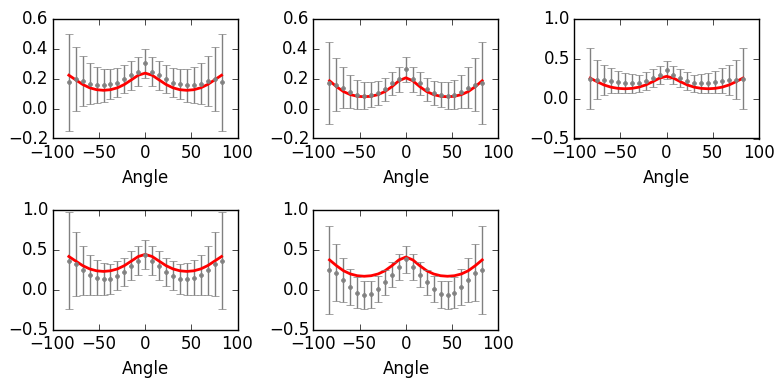

In [29]:
figure(figsize=(8, 4))
for dix in 1:length(data)
    rs = data[dix][:counts] # retrieve the neural data
    ncond, nnrn, ntrial = size(rs) # and its dimensions
    
    # infer the hyper parameters
    Δ, σs, σn, scr = GP.infer(rs; Δ0=0.2, Δmin=0.1, σsmin=1e-3, σnmin=1e-3)
    println("a$dix Δ: $Δ, σs: $σs, σn: $σn, SNR: $(σs^2/σn^2), scr: $scr")
    data[dix][:Δ], data[dix][:σs], data[dix][:σn] = Δ, σs, σn # save fitted values
    
    # compute data derived, and fitted covariance functions
    ker, θs = Kernel(Δ), linspace(-90, 90, 2ncond+1)[2:end-1]
    tmp = squeeze(mean(rs, 3), 3)
    # estimating the covariance of the data
    C = tmp * tmp' / nnrn
    data_cov = Float64[mean(C[diagm(ones(ncond - abs(offset)), offset) .> 0.5]) for offset in -(ncond - 1):(ncond - 1)]
    # fitted kernel
    fitted_cov = σs^2 * val(θs / 90 * 2π, ker)
    fitted_cov_std = sqrt(σs^4 * (1 + 2 * GP.val(θs / 90 * 2π, ker).^2) - σs^4 * GP.val(θs / 90 * 2π, ker).^2)
    fitted_cov_stderr = fitted_cov_std ./ sqrt(ncond - abs(-(ncond - 1):(ncond - 1)))
    
    # plot them
    subplot(2, 3, dix)
    PyPlot.locator_params(nbins=4)
    plot(θs, fitted_cov, "r", linewidth=2)
    errorbar(θs, data_cov, yerr=fitted_cov_stderr, fmt=".", color="grey")
    xlabel("Angle")
end
tight_layout()

### Distribution of likelihood scores across neurons vs. synthetic

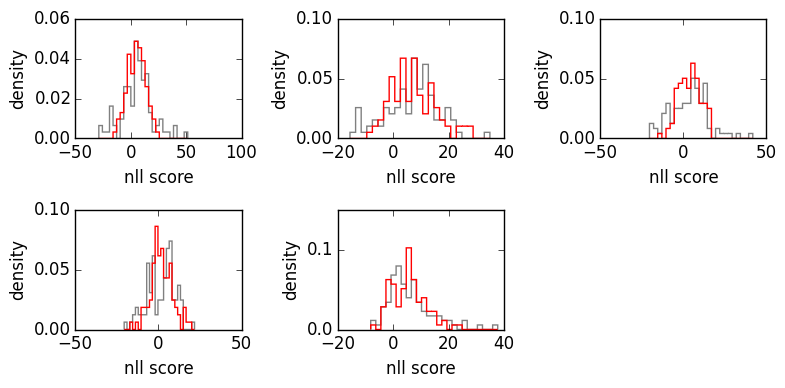

In [30]:
figure(figsize=(8, 4))

for dix in 1:length(data)
    rs = data[dix][:counts]
    ncond, nnrn, ntrial = size(rs)
    Δ, σs, σn = data[dix][:Δ], data[dix][:σs], data[dix][:σn]
    
    # plot the histogram of nll scores for real neurons vs synthetic data with fitted parameters
    nrn_scrs = Float64[GP.nll_helper!(rs[:, nix, :], Δ, σs, σn) for nix in 1:nnrn]
    θs, xs = tc(ncond, nnrn * 10, Kernel(Δ))
    rs_syn = zeros(ncond, nnrn * 10, ntrial)
    for t in 1:ntrial
        rs_syn[:, :, t] = xs * σs + randn(ncond, nnrn * 10) * σn
    end
    syn_scrs = Float64[GP.nll_helper!(rs_syn[:, nix, :], Δ, σs, σn) for nix in 1:nnrn]
    range = Float64[minimum([nrn_scrs; syn_scrs]); maximum([nrn_scrs; syn_scrs])]
    
    # plot histograms
    subplot(2, 3, dix)
    PyPlot.locator_params(nbins=3)
    plt[:hist](nrn_scrs, bins=25, range=range, normed=true, histtype="step", color="grey")
    plt[:hist](syn_scrs, bins=25, range=range, normed=true, histtype="step", color="r")
    xlabel("nll score"); ylabel("density")
end
tight_layout()

### Prediction using fitted tuning curves

In [31]:
# actual prediction function
function predict(rs_train, θs_train, θpred, Δ, σs, σn)    
    ker = Kernel(Δ)
    # covariance of the training data
    Σ = val(θs_train .- θs_train', ker) * σs^2 + eye(length(θs_train)) * σn^2
    Σinv = inv(Σ) # inverse
    # cross covariance between training and testing location
    Ρ = val(θpred .- θs_train', ker) * σs^2 
    
    # return prediction and the variance of the predicted value
    return (Ρ * Σinv * rs_train)[:], σs^2 + σn^2 - (Ρ * Σinv * Ρ')[1]
end

predict (generic function with 1 method)

In [39]:
# run simulations, 1:skip:end => training trials
ntry, skips = 1000, float([1, 2, 3, 4, 6])
# storage of predicted response and actual responses
# num datasets by num possible step sizes
rs_true = Array(Any, length(data), length(skips))
rs_pred = Array(Any, length(data), length(skips))
err_theory = Array(Any, length(data), length(skips))

for dix in 1:length(data), (skipix, skip) in enumerate(skips)
    info(" dix: $dix, skip: $skip")
    # fitted hyper parameters
    Δ, σs, σn = data[dix][:Δ], data[dix][:σs], data[dix][:σn]
        
    # firing rates
    rs = data[dix][:counts]
    ncond, nnrn, ntrial = size(rs)
    θs = linspace(0, 2π, ncond+1)[1:ncond]
    # preallocation results
    rs_true[dix, skipix] = zeros(0)
    rs_pred[dix, skipix] = zeros(0)
    err_theory[dix, skipix] = zeros(0)
    # loop over all possible offsets (i.e. 1:step:end, 2:step:end, ..., (step-1):step:end
    for offset in 1:skip, ix in 1:round(Int64, ntry/skip)
        # indices for training and testing conditions
        train_mask = zeros(Bool, ncond)
        train_mask[offset:skip:end] = true
        train_ix = find(train_mask)
        test_ix = rand(1:ncond, 1)
        # train trial indicies
        train_trial, test_trial = randperm(ntrial)[1:2]
        # store true response
        r_true = vec(rs[test_ix, :, test_trial])
        # store predicted responses and predicted errors
        r_pred, err_th = predict(rs[train_ix, :, train_trial], θs[train_ix], θs[test_ix], Δ, σs, σn)
        
        push!(rs_true[dix, skipix], r_true...)
        push!(rs_pred[dix, skipix], r_pred...)
        push!(err_theory[dix, skipix], err_th)
    end
end

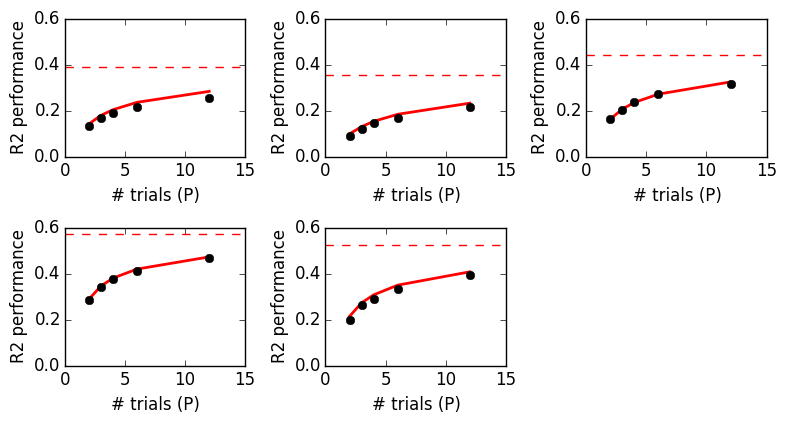

In [40]:
# plot the results
fig = figure(figsize=(8, 6))

errs, errs_th = zeros(length(skips)), zeros(length(skips))
for dix in 1:length(data)
    Δ, σs, σn = data[dix][:Δ], data[dix][:σs], data[dix][:σn]
    ncond = size(data[dix][:counts], 1)
    for (skipix, skip) in enumerate(skips)
        # computes actual prediction error (normalized)
        errs[skipix] = mean((rs_true[dix, skipix] - rs_pred[dix, skipix])[:].^2) / (σs^2 + σn^2)
        # computes theoretical prediction error (normalized)
        errs_th[skipix] = mean(err_theory[dix, skipix][:]) / (σs^2 + σn^2)
    end    

    subplot(3, 3, dix)
    PyPlot.locator_params(nbins=3)
    # plot theoretical errors
    plot(ncond ./ skips, 1 - errs_th, "r-", linewidth=2)
    # plot actual error
    plot(ncond ./ skips, 1 - errs, "ko")
    # plot the infinite data limit
    PyPlot.axhline(1 - σn^2 / (σs^2 + σn^2), linestyle="--", color="r")
    ylim([0.0, 0.6]); xlabel("# trials (P)"); ylabel("R2 performance")
end
tight_layout()